In [16]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


def plot_temporal_themes(csv_path, themes, date_col="date", text_col="review_text", 
                         date_format="%d/%m/%Y", title="Quarterly Theme Trends", 
                         figsize=(12, 6)):

    # =========================
    # 1. LOAD DATA
    # =========================
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.lower()
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors="coerce")
    df = df.dropna(subset=[date_col])

    # =========================
    # 2. THEME MATCHING
    # =========================
    def assign_themes(text):
        text = str(text).lower()
        matched = []
        for theme, keywords in themes.items():
            for kw in keywords:
                if re.search(r"\b" + re.escape(kw) + r"\b", text):
                    matched.append(theme)
                    break
        return matched

    df["themes"] = df[text_col].apply(assign_themes)
    df = df.explode("themes").dropna(subset=["themes"])

    # =========================
    # 3. MONTHLY DATA (SOURCE OF TRUTH)
    # =========================
    df["month"] = df[date_col].dt.to_period("M").dt.to_timestamp()

    pivot_df = (
        df.groupby(["month", "themes"])
          .size()
          .unstack(fill_value=0)
          .sort_index()
    )

    # =========================
    # 4. PEAK DETECTION
    # =========================
    max_theme = pivot_df.sum().idxmax()
    max_month_value = pivot_df[max_theme].max()
    max_month_date = pivot_df[max_theme].idxmax()

    # =========================
    # 5. PLOT (create_line_graph STYLE)
    # =========================
    plt.figure(figsize=figsize)

    months = list(pivot_df.index)
    x_positions = range(len(months))
    colors = plt.cm.Dark2(np.linspace(0, 1, len(pivot_df.columns)))

    for theme, color in zip(pivot_df.columns, colors):
        plt.plot(
            x_positions,
            pivot_df[theme].values,
            linewidth=1.5,
            color=color,
            label=theme
        )

    # =========================
    # 6. QUARTERLY X-AXIS LABELS (VISUAL ONLY)
    # =========================
    xticks, xlabels = [], []

    for i, dt in enumerate(months):
        if dt.month in [1, 4, 7, 10]:
            q = (dt.month - 1) // 3 + 1
            xticks.append(i)
            xlabels.append(f"Q{q} {dt.year}")

    if x_positions[-1] not in xticks:
        last = months[-1]
        q = (last.month - 1) // 3 + 1
        xticks.append(len(months) - 1)
        xlabels.append(f"Q{q} {last.year}")

    plt.xticks(xticks, xlabels, rotation=90, fontsize=9)

    # =========================
    # 7. PEAK ANNOTATION
    # =========================
    peak_x = months.index(max_month_date)

    plt.annotate(
        f"Peak: {max_month_date.strftime('%b %Y')}\n{int(max_month_value)} reviews",
        xy=(peak_x, max_month_value),
        xytext=(peak_x, max_month_value * 1.15),
        ha="center",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
        arrowprops=dict(arrowstyle="->", color="red"),
        fontsize=10
    )

    plt.axvline(x=peak_x, linestyle="--", color="red", alpha=0.3)

    plt.title(title, fontsize=12, fontweight="bold")
    plt.xlabel("Quarter")
    plt.ylabel("Reviews")

    plt.grid(True, axis="y", alpha=0.15)
    plt.grid(True, axis="x", alpha=0.05)
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # =========================
    # 9. SUMMARY
    # =========================
    print("=" * 60)
    print("PEAK ANALYSIS SUMMARY")
    print("=" * 60)
    print(f"Peak Theme: {max_theme}")
    print(f"Peak Month: {max_month_date.strftime('%B %Y')}")
    print(f"Monthly Peak Value: {int(max_month_value)} reviews")
    print("=" * 60)


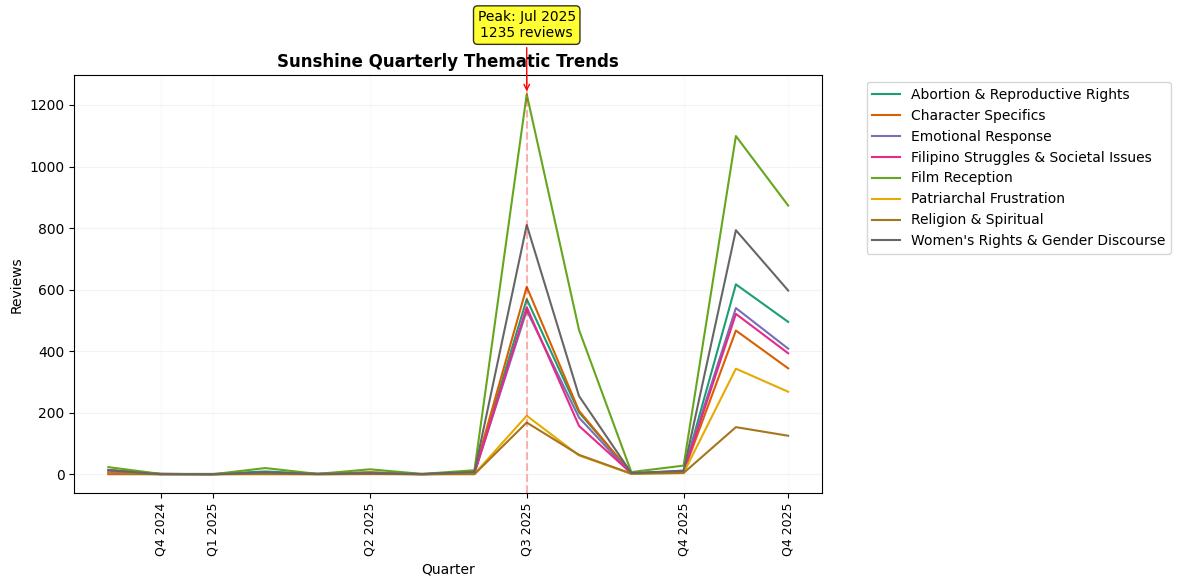

PEAK ANALYSIS SUMMARY
Peak Theme: Film Reception
Peak Month: July 2025
Monthly Peak Value: 1235 reviews


In [17]:
sunshine_themes = {
    "Abortion & Reproductive Rights": [
        "abortion", "legalize", "healthcare", "pregnancy",
        "teenage pregnancy", "aborsyon", "hope"
    ],
    "Women's Rights & Gender Discourse": [
        "women", "woman", "body", "kababaihan", "society",
        "pangarap", "aspirations", "motherhood", "ayoko maging"
    ],
    "Film Reception": [
        "watch", "good", "film", "ending", "ganda", "galing",
        "love", "thank", "masterpiece", "cinema", "best", "lakas", "real"
    ],
    "Patriarchal Frustration": [
        "fuck men", "men", "hate", "lalaki", "lalake"
        "tangina lalaki", "putangina", "tito bobot"
    ],
    "Filipino Struggles & Societal Issues": [
        "hirap", "hirap maging", "pilipinas", "pangarap",
        "maging pilipinas", "country", "iyak", "held", "breaking",
        "puta"
    ],
    "Emotional Response": [
        "mahal", "ily", "love", "ramdam", "undestand",
        "cried", "tears", "love love", "hug", "shine", "loved",
        "realistic", "reality"
    ],
    "Character Specifics": [
        "maris racal", "miggy", "elijah", "actress",
        "performance", "peak", "galing", "canlas", "naiintindihan"
    ],
    "Religion & Spiritual": [
        "god", "pastor", "papa god", "thank"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/sunshine_reviews.csv",
                     themes=sunshine_themes,
                     title="Sunshine Quarterly Thematic Trends")

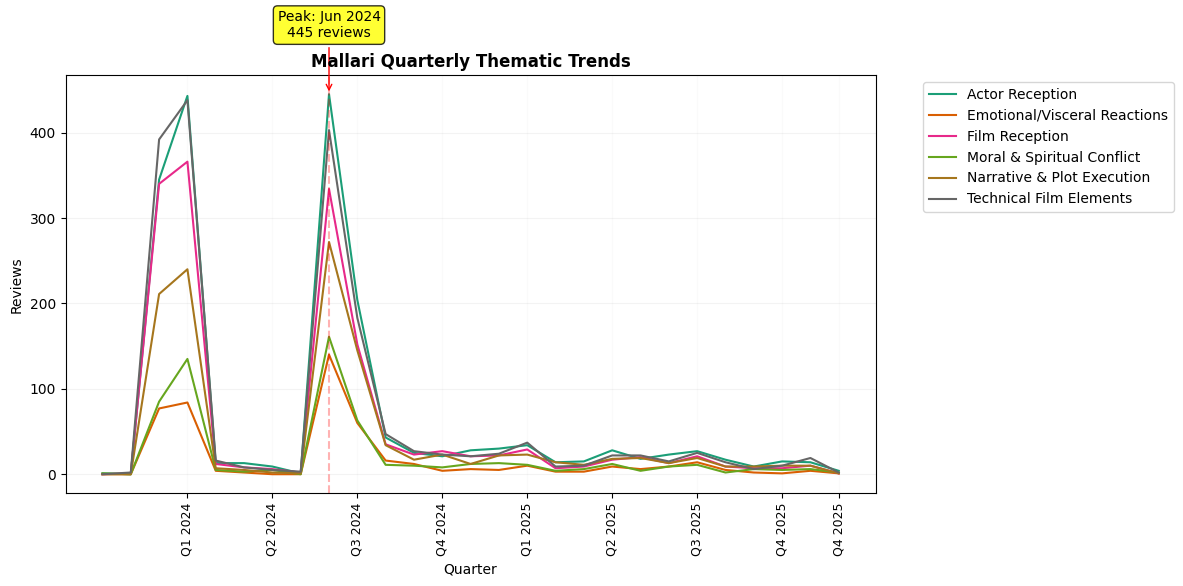

PEAK ANALYSIS SUMMARY
Peak Theme: Actor Reception
Peak Month: June 2024
Monthly Peak Value: 445 reviews


In [18]:
mallari_themes = {
    "Actor Reception": [
        "piolo", "pascual", "pogi", "acting", "hot", "biceps", "stars", "papa", "pogi papa", "janella", "salvador"
    ],
    "Technical Film Elements": [
        "horror", "film", "movies", "good", "scary", "jumpscares", "cinematography", "cinematic", "plot"
    ],
    "Narrative & Plot Execution": [
        "ideas", "wasted", "ending", "time travel", "multiverse", "story", "concept", "disappointing", "poorly"
    ],
    "Emotional/Visceral Reactions": [
        "fuck", "shit", "tangina", "dumb", "cried", "scary", "curse"
    ],
    "Moral & Spiritual Conflict": [
        "father severino", "papa", "curse", "generational trauma"
    ],
    "Film Reception": [
        "Plot", "good", "film", "movies", "best", "entertaining", "watch", "like"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/mallari_reviews.csv",
                     themes=mallari_themes,
                     title="Mallari Quarterly Thematic Trends")

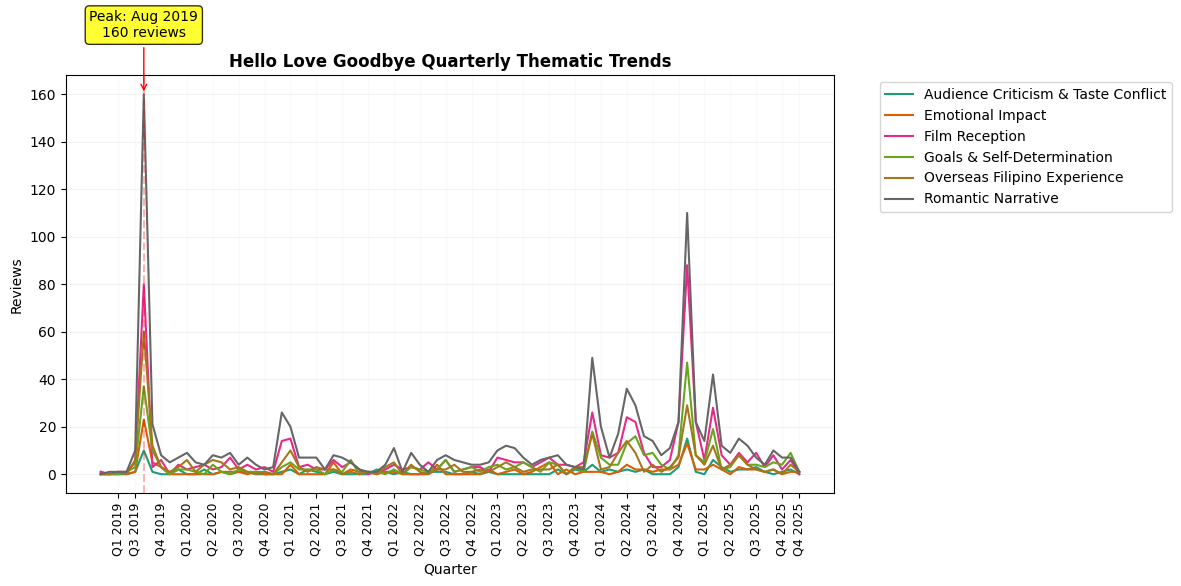

PEAK ANALYSIS SUMMARY
Peak Theme: Romantic Narrative
Peak Month: August 2019
Monthly Peak Value: 160 reviews


In [19]:
hellolovegoodbye_themes = {
    "Romantic Narrative": [
        "love", "story", "romance", "relationships", "film"
    ],
    "Goals & Self-Determination": [
        "dreams", "choose", "career", "pangarap", "sarili", "canada"
    ],
    "Overseas Filipino Experience": [
        "hong kong", "hk", "overseas", "land", "version", "pinoy", "philippines"
    ],
    "Film Reception": [
        "watched", "rewatch", "rewatched", "rewatching", "maganda", "ganda", "good"
    ],
    "Emotional Impact": [
        "cried", "tears", "sad", "depressing", "kms"
    ],
    "Audience Criticism & Taste Conflict": [
        "corny", "baduy", "version", "maine", "anong"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/hellolovegoodbye_reviews.csv",
                     themes=hellolovegoodbye_themes,
                     title="Hello Love Goodbye Quarterly Thematic Trends")

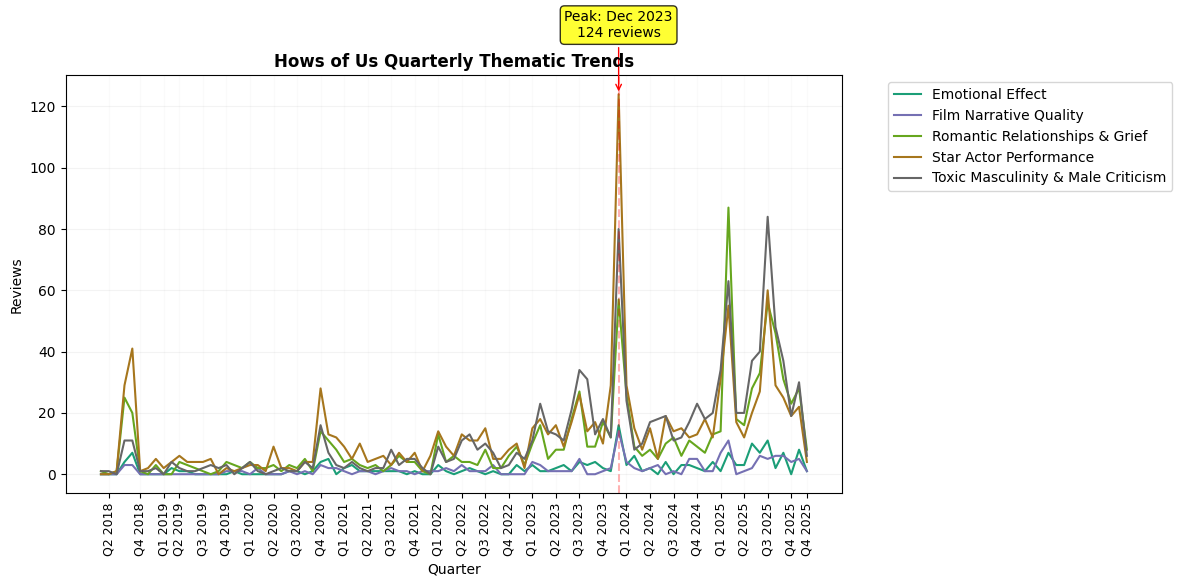

PEAK ANALYSIS SUMMARY
Peak Theme: Star Actor Performance
Peak Month: December 2023
Monthly Peak Value: 124 reviews


In [20]:
howsofus_themes = {
    "Romantic Relationships & Grief": [
        "love", "relationship", "heart", "stay", "reason", "rewatch", "watch", "great film", "love love", "binalikan", "nagkabalikan", "sakit", "hurt", "left", "ramdam"
    ],
    "Toxic Masculinity & Male Criticism": [
        "fuck men", "tangina primo", "red flag", "tangina", "hate", "boy", "primo"
    ],
    "Star Actor Performance": [
        "kathryn", "kathniel", "daniel", "acting", "carried", "stars", "performance"
    ],
    "Film Narrative Quality": [
        "plot ", "corny", "panget", "music", "unnecessary jokes", "opm"
    ],
    "Emotional Effect": [
        "cried", "sobbed", "crying", "eyes", "sakit", "hurts"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/howsofus_reviews.csv",
                     themes=howsofus_themes,
                     title="Hows of Us Quarterly Thematic Trends")

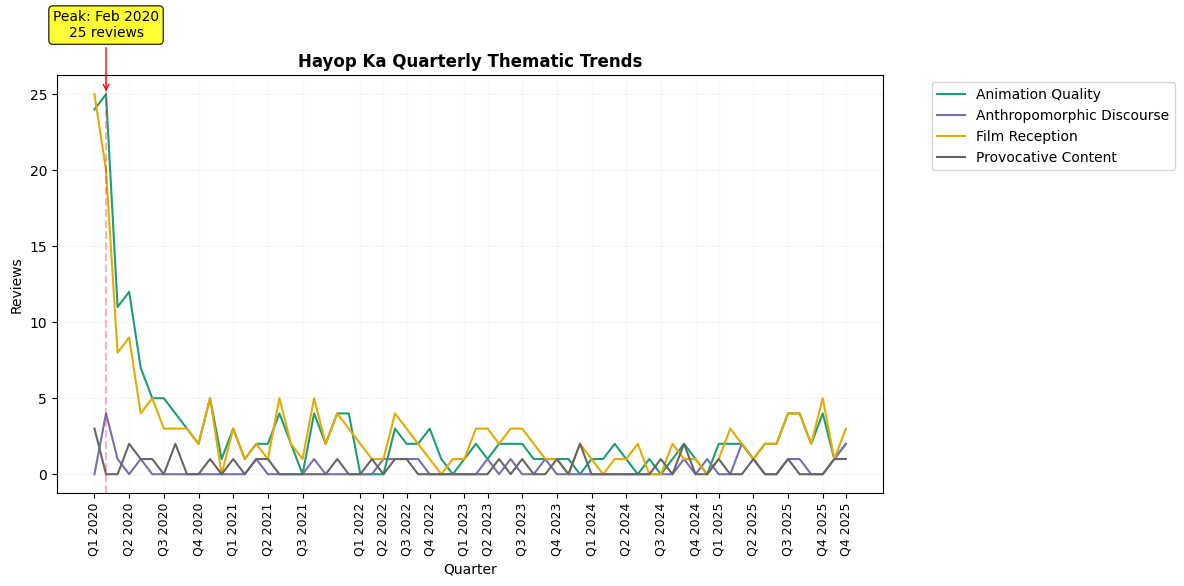

PEAK ANALYSIS SUMMARY
Peak Theme: Animation Quality
Peak Month: February 2020
Monthly Peak Value: 25 reviews


In [21]:
hayopka_themes = {
    "Animation Quality": [
        "animation", "animated", "ganda", "ganda animation", "stars animation", "visuals"
    ],
    "Film Reception": [
        "story", "plot", "good", "sayang", "really", "just", "film", "10", "10/10", "good film"
    ],
    "Provocative Content": [
        "kantot", "sexy", "boyfriend", "horny", "adult"
    ],
    "Anthropomorphic Discourse": [
        "furry", "zootopia", "wattpad", "furry wattpad"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/hayopka_reviews.csv",
                     themes=hayopka_themes,
                     title="Hayop Ka Quarterly Thematic Trends")

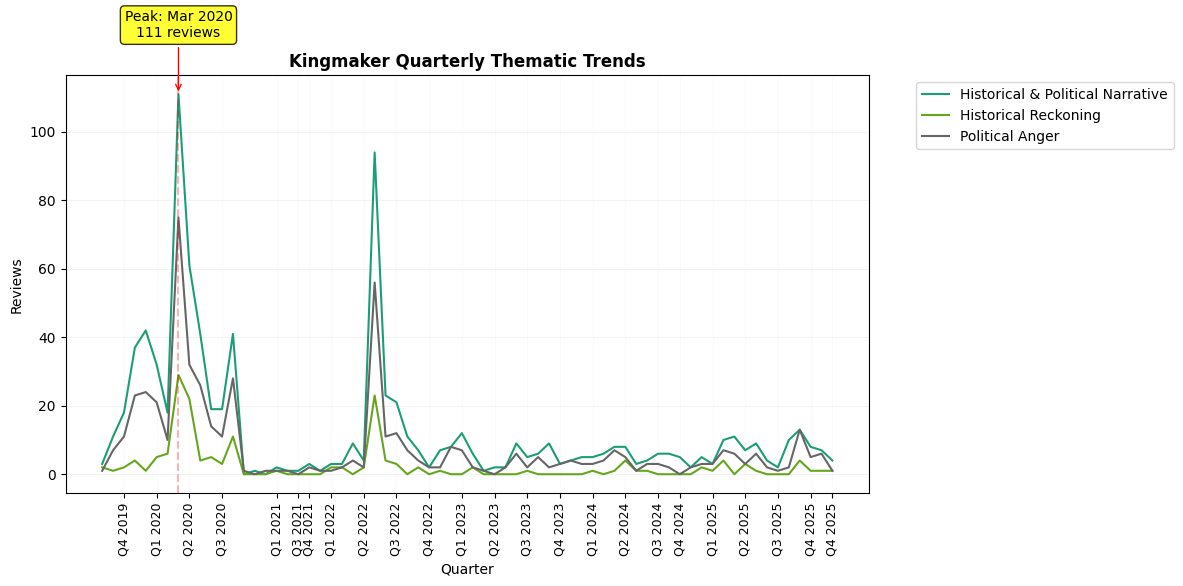

PEAK ANALYSIS SUMMARY
Peak Theme: Historical & Political Narrative
Peak Month: March 2020
Monthly Peak Value: 111 reviews


In [22]:
kingmaker_themes = {
    "Historical & Political Narrative": [
        "marcos", "imelda", "documentary", "people", "film", "truth", "real truth"
    ],
    "Political Anger": [
        "tangina", "marcos", "family tangina", "fuck marcoses", "rich"
    ],
    "Historical Reckoning": [
        "Truth", "perception", "neveragain", "neverforget", "forget"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/kingmaker_reviews.csv",
                     themes=kingmaker_themes,
                     title="Kingmaker Quarterly Thematic Trends")

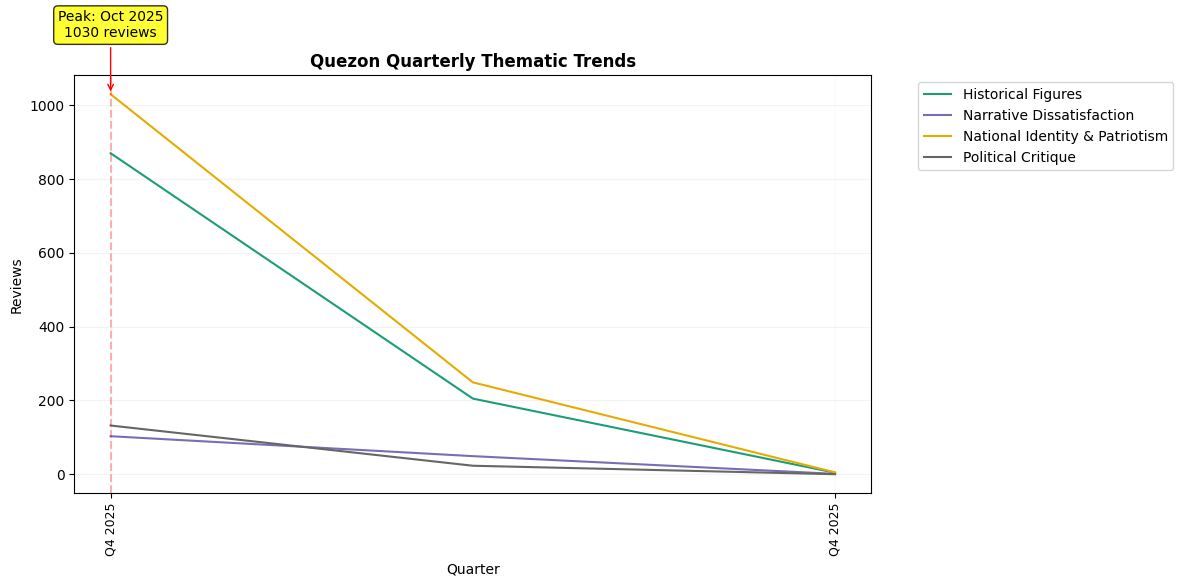

PEAK ANALYSIS SUMMARY
Peak Theme: National Identity & Patriotism
Peak Month: October 2025
Monthly Peak Value: 1030 reviews


In [23]:
quezon_themes = {
    "National Identity & Patriotism": [
        "quezon", "film", "philippines", "people", "bansa", "bayan", "ating"
    ],
    "Historical Figures": [
        "osmeña", "sergio", "enrile", "aguinaldo", "quezon"
    ],
    "Political Critique": [
        "trapo", "burat", "pastilan", "lamang"
    ],
    "Narrative Dissatisfaction": [
        "toxic", "doomed", "old yaoi", "yaoi"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/quezon_reviews.csv",
                     themes=quezon_themes,
                     title="Quezon Quarterly Thematic Trends")

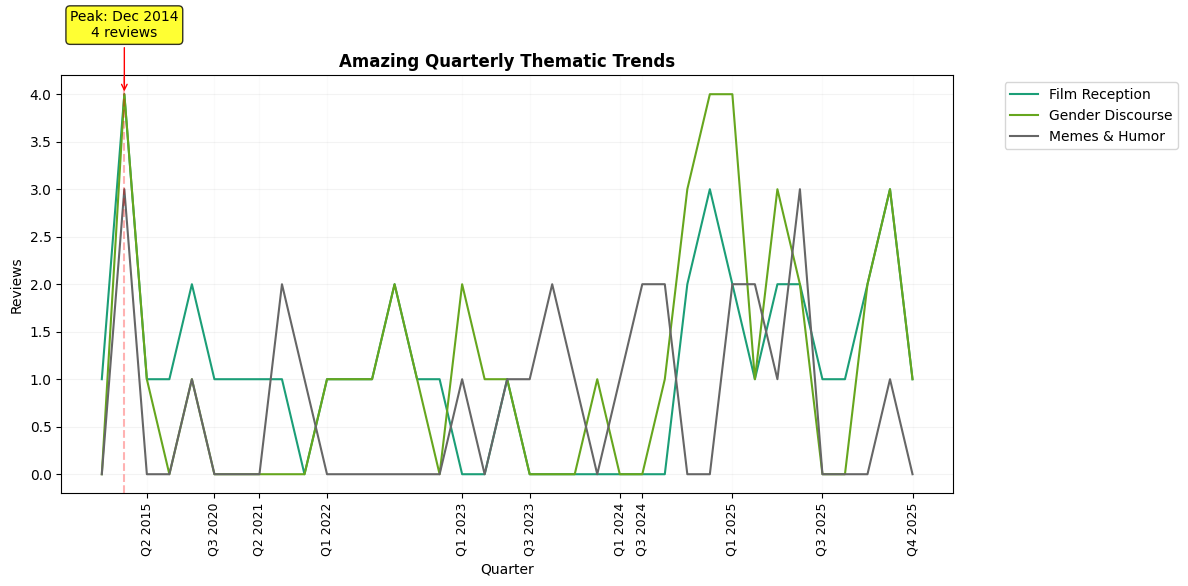

PEAK ANALYSIS SUMMARY
Peak Theme: Film Reception
Peak Month: December 2014
Monthly Peak Value: 4 reviews


In [24]:
amazing_themes = {
    "Film Reception": [
        "film", "vice", "ganda", "vice ganda"
    ],
    "Gender Discourse": [
        "bakla", "vice", "alex", "gay"
    ],
    "Memes & Humor": [
        "zombies", "plants vs zombies", "boom panes", "bimbee", "bomb", "boom"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/amazing_reviews.csv",
                     themes=amazing_themes,
                     title="Amazing Quarterly Thematic Trends")

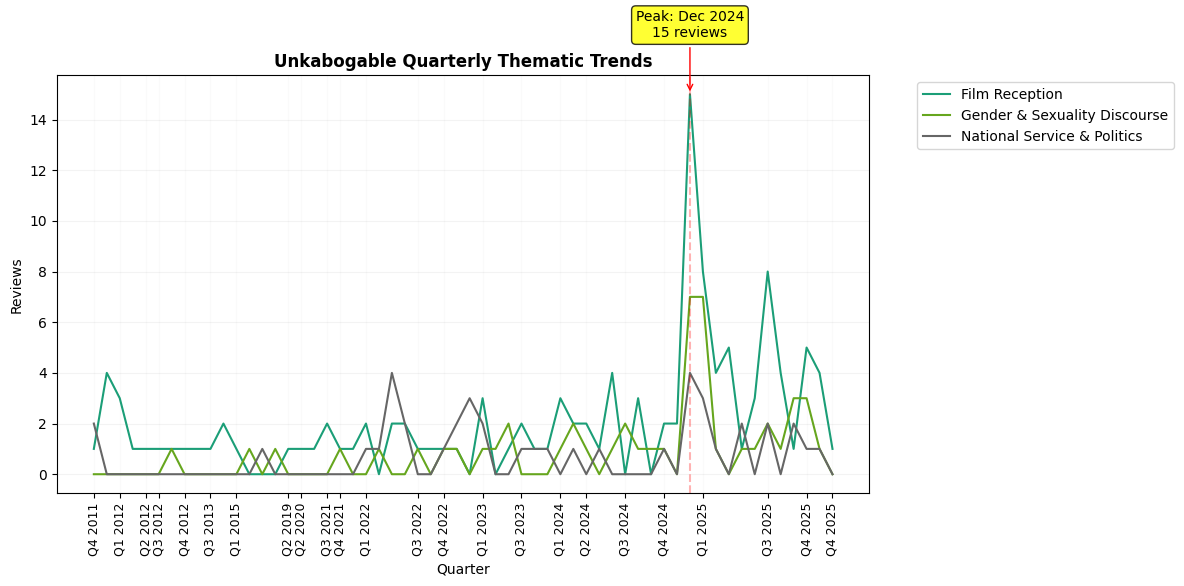

PEAK ANALYSIS SUMMARY
Peak Theme: Film Reception
Peak Month: December 2024
Monthly Peak Value: 15 reviews


In [25]:
unkabogable_themes = {
    "Gender & Sexuality Discourse": [
        "gay", "bakla", "homophobia", "homophobic", "pro", "mulan gay"
    ],
    "National Service & Politics": [
        "rotc", "mandatory", "military service", "service", "camp"
    ],
    "Film Reception": [
        "vice", "vice ganda", "comedy", "ganda", "film"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/unkabogable_reviews.csv",
                     themes=unkabogable_themes,
                     title="Unkabogable Quarterly Thematic Trends")

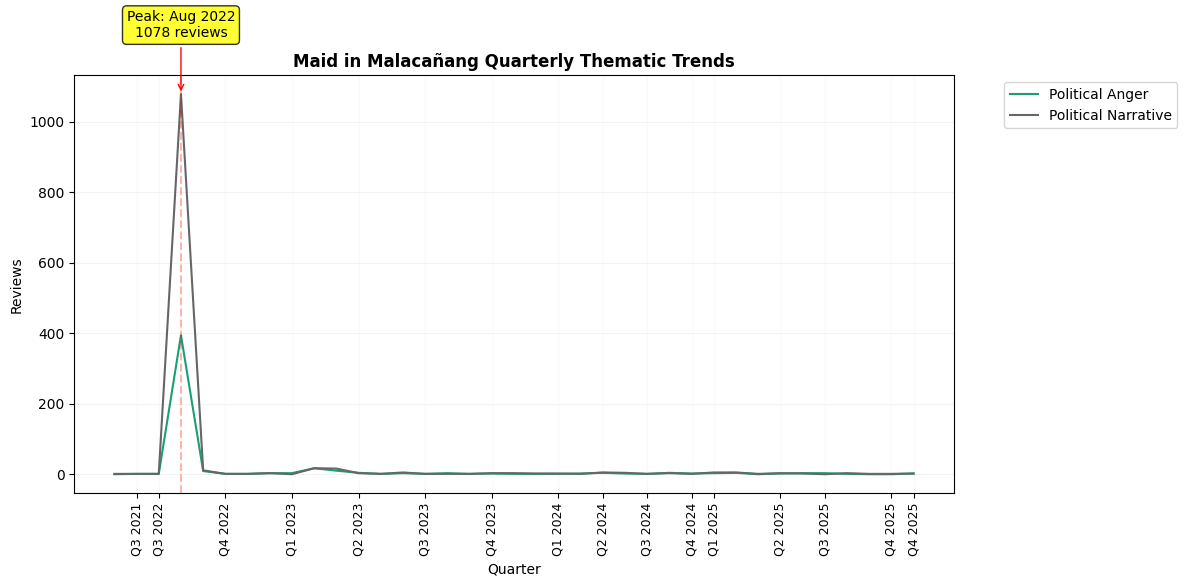

PEAK ANALYSIS SUMMARY
Peak Theme: Political Narrative
Peak Month: August 2022
Monthly Peak Value: 1078 reviews


In [26]:
maid_themes = {
    "Political Narrative": [
        "history", "marcos", "family", "malacañang", "film", "documentary", "legacy"
    ],
    "Political Anger": [
        "pangit", "basura", "tangina", "putangina", "marcos", "basura marcos"
    ]
}

plot_temporal_themes(csv_path="Review Data (TTA)/maid_reviews.csv",
                     themes=maid_themes,
                     title="Maid in Malacañang Quarterly Thematic Trends")